<a href="https://colab.research.google.com/github/LucasMelvin15/Machine-Learning-Projects/blob/main/02.foodvision_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries
import torch
from torch import nn

In [2]:
# set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Set up path to data folder
data_path = Path("data")
image_path = data_path / "food_images"

# If the image folder doesn't exist, create it
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download food data
    zip_file_path = data_path / "food_images20_percent.zip"
    with open(zip_file_path, "wb") as f:
        print("Downloading chicken wings, pork chops, pizza, tacos, steak data...")
        response = requests.get("https://github.com/LucasMelvin15/Machine-Learning-Projects/raw/main/data/food_images20_percent.zip")
        if response.status_code == 200:
            f.write(response.content)
            print("Download complete.")
        else:
            print(f"Failed to download data. Status code: {response.status_code}")
            exit()

    # Unzip food data
    try:
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            print("Extracting data...")
            zip_ref.extractall(image_path)
            print("Extraction complete.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")


Did not find data/food_images directory, creating one...
Download complete.
Extracting data...
Extraction complete.


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/food_images'.
There are 5 directories and 0 images in 'data/food_images/test'.
There are 0 directories and 49 images in 'data/food_images/test/tacos'.
There are 0 directories and 47 images in 'data/food_images/test/pizza'.
There are 0 directories and 52 images in 'data/food_images/test/pork_chop'.
There are 0 directories and 53 images in 'data/food_images/test/steak'.
There are 0 directories and 49 images in 'data/food_images/test/chicken_wings'.
There are 5 directories and 0 images in 'data/food_images/train'.
There are 0 directories and 128 images in 'data/food_images/train/tacos'.
There are 0 directories and 164 images in 'data/food_images/train/pizza'.
There are 0 directories and 143 images in 'data/food_images/train/pork_chop'.
There are 0 directories and 162 images in 'data/food_images/train/steak'.
There are 0 directories and 153 images in 'data/food_images/train/chicken_wings'.


In [6]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/food_images/train'), PosixPath('data/food_images/test'))

## Visualize an image

Random image path: data/food_images/train/steak/612551.jpg
Image class: steak
Image height: 512
Image width: 509


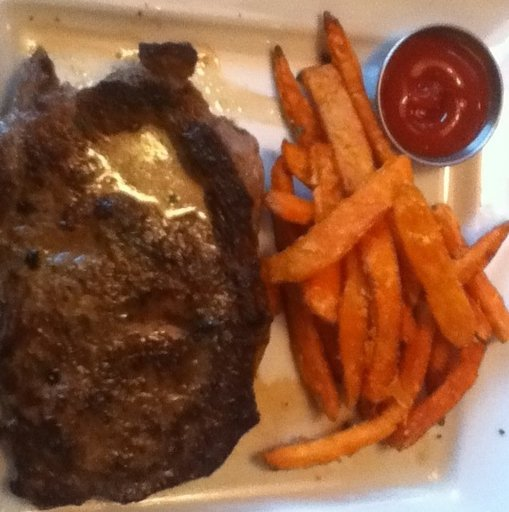

In [7]:
import random
from PIL import Image

# set up seed
#random.seed(42)

# 1. get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## Transforming data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [13]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    #normalize the image with mean and std for each image
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Randomly crop the image to 60x60 and then resize back to 64x64
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

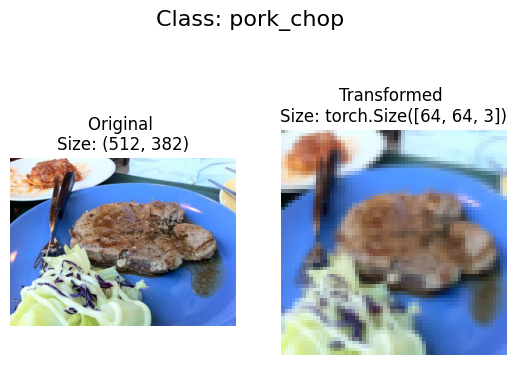

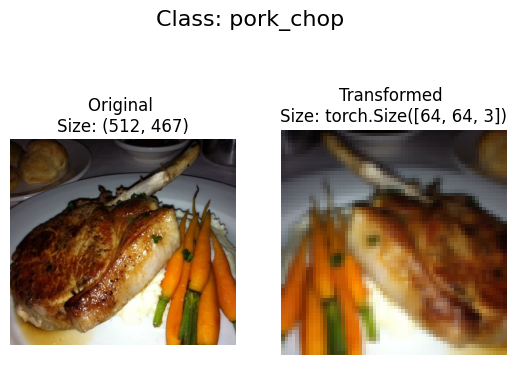

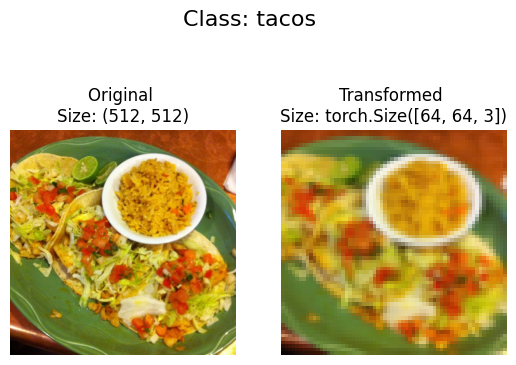

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Loading data using ImageFolder

In [15]:
from torchvision import datasets
train_data = datasets.ImageFolder(
               root=train_dir,
               transform=data_transform,
               target_transform=None)

test_data = datasets.ImageFolder(
               root=test_dir,
               transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")


Train data:
Dataset ImageFolder
    Number of datapoints: 750
    Root location: data/food_images/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 250
    Root location: data/food_images/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )


In [16]:
# get class names as a list
class_names = train_data.classes
class_names

['chicken_wings', 'pizza', 'pork_chop', 'steak', 'tacos']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'chicken_wings': 0, 'pizza': 1, 'pork_chop': 2, 'steak': 3, 'tacos': 4}

In [18]:
len(train_data) , len(test_data)

(750, 250)

In [19]:
# find samples and their target lables
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.2667, 0.2588, 0.2510,  ..., 0.2471, 0.2510, 0.2510],
         [0.2627, 0.2549, 0.2510,  ..., 0.2745, 0.3098, 0.3412],
         [0.2627, 0.2588, 0.2510,  ..., 0.2941, 0.3569, 0.4157],
         ...,
         [0.9569, 0.9765, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.7686, 0.8784, 0.9490,  ..., 1.0000, 1.0000, 1.0000],
         [0.5294, 0.6039, 0.7333,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.3098, 0.3020, 0.2980,  ..., 0.2824, 0.2863, 0.2863],
         [0.3059, 0.2980, 0.2941,  ..., 0.3059, 0.3451, 0.3843],
         [0.3059, 0.3020, 0.2980,  ..., 0.3216, 0.3922, 0.4588],
         ...,
         [0.9725, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.8039, 0.8980, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
         [0.5686, 0.6392, 0.7647,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0157, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.1020, 0.1608],
         [0.0039, 0.0039, 0.0039,  ..., 0.07

## Plot a single image tensor using matplotlib

Original shape:torch.Size([3, 64, 64])-> [C,H,W] 
Image permute shape:torch.Size([64, 64, 3])-> [C,H,W] 


Text(0.5, 1.0, 'chicken_wings')

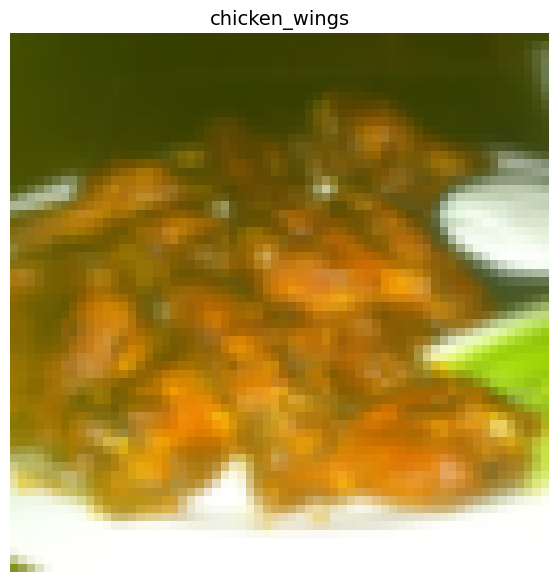

In [21]:
#rearrange the order of dimensions
img_permute = img.permute(1,2,0)

#print out the original before permute
print(f"Original shape:{img.shape}-> [C,H,W] ")
print(f"Image permute shape:{img_permute.shape}-> [C,H,W] ")

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title(class_names[label], fontsize=14)

## Turn loaded images into DataLoaders

In [22]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b676e198970>,
 <torch.utils.data.dataloader.DataLoader at 0x7b676e198760>)

In [23]:
# check the shape of our iterable data
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Model 0: Replicating the TinyVGG architecture without data augmentation

In [24]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

## Creates a simple transform for data

In [25]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7b676e199900>,
 <torch.utils.data.dataloader.DataLoader at 0x7b676d40d150>)

In [26]:

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion



In [27]:
#set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#instanciate the model
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5, bias=True)
  )
)

# try a forward pass on a single image (to test the model)

In [28]:
# 1. Get a batch of images and labels from the dataloader
img_batch, label_batch = next(iter(train_dataloader_simple))

# Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0778,  0.0424,  0.0307, -0.0190, -0.0280]])

Output prediction probabilities:
tensor([[0.2116, 0.2042, 0.2018, 0.1921, 0.1903]])

Output prediction label:
tensor([0])

Actual label:
0


In [29]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Create train and test loop functions

In [30]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [33]:
# create a train to combine train and step functions
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Train and evaluate model

In [34]:
# set random seed
torch.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 10

# recreate an instance of tinyvgg
model_0 = TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
model_0

# set up a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

#start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6097 | train_acc: 0.2108 | test_loss: 1.6132 | test_acc: 0.1836
Epoch: 2 | train_loss: 1.6064 | train_acc: 0.2202 | test_loss: 1.6154 | test_acc: 0.1836
Epoch: 3 | train_loss: 1.6059 | train_acc: 0.2202 | test_loss: 1.6161 | test_acc: 0.1836
Epoch: 4 | train_loss: 1.6056 | train_acc: 0.2254 | test_loss: 1.6156 | test_acc: 0.1875
Epoch: 5 | train_loss: 1.6050 | train_acc: 0.2249 | test_loss: 1.6158 | test_acc: 0.1836
Epoch: 6 | train_loss: 1.6047 | train_acc: 0.2152 | test_loss: 1.6160 | test_acc: 0.1836
Epoch: 7 | train_loss: 1.6038 | train_acc: 0.2576 | test_loss: 1.6132 | test_acc: 0.2617
Epoch: 8 | train_loss: 1.6007 | train_acc: 0.2416 | test_loss: 1.6136 | test_acc: 0.1992
Epoch: 9 | train_loss: 1.5955 | train_acc: 0.2777 | test_loss: 1.6113 | test_acc: 0.2578
Epoch: 10 | train_loss: 1.5873 | train_acc: 0.3173 | test_loss: 1.6044 | test_acc: 0.2656
Total training time: 72.782 seconds


## Model 1: Replicating TinyVGG model architecture with data augmentation

In [35]:
# create a transform with data augmentation
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [36]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 750
     Root location: data/food_images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 250
     Root location: data/food_images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [37]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b677051fd30>,
 <torch.utils.data.dataloader.DataLoader at 0x7b676e198760>)

## Construct and train model 1

In [38]:

device = "cuda" if torch.cuda.is_available() else "cpu"
#instanciate the model
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5, bias=True)
  )
)

### Train model 1

In [41]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6003 | train_acc: 0.2370 | test_loss: 1.6049 | test_acc: 0.2227
Epoch: 2 | train_loss: 1.5929 | train_acc: 0.2569 | test_loss: 1.5876 | test_acc: 0.2891
Epoch: 3 | train_loss: 1.5733 | train_acc: 0.3168 | test_loss: 1.5617 | test_acc: 0.2930
Epoch: 4 | train_loss: 1.5642 | train_acc: 0.3065 | test_loss: 1.5422 | test_acc: 0.3164
Epoch: 5 | train_loss: 1.5421 | train_acc: 0.2794 | test_loss: 1.5459 | test_acc: 0.2305
Epoch: 6 | train_loss: 1.5257 | train_acc: 0.3192 | test_loss: 1.5271 | test_acc: 0.3086
Epoch: 7 | train_loss: 1.5091 | train_acc: 0.3166 | test_loss: 1.5094 | test_acc: 0.3104
Epoch: 8 | train_loss: 1.5075 | train_acc: 0.3105 | test_loss: 1.4770 | test_acc: 0.3323
Epoch: 9 | train_loss: 1.4749 | train_acc: 0.3547 | test_loss: 1.5089 | test_acc: 0.3143
Epoch: 10 | train_loss: 1.4878 | train_acc: 0.3149 | test_loss: 1.4865 | test_acc: 0.3173
Total training time: 75.565 seconds


## Compare model results


In [42]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.609666   0.210751   1.613232  0.183594
 1    1.606397   0.220238   1.615447  0.183594
 2    1.605865   0.220238   1.616114  0.183594
 3    1.605576   0.225446   1.615632  0.187500
 4    1.604974   0.224888   1.615819  0.183594
 5    1.604741   0.215216   1.615984  0.183594
 6    1.603802   0.257626   1.613208  0.261719
 7    1.600688   0.241629   1.613565  0.199219
 8    1.595453   0.277716   1.611265  0.257812
 9    1.587337   0.317336   1.604385  0.265625,
    train_loss  train_acc  test_loss  test_acc
 0    1.600305   0.236979   1.604905  0.222656
 1    1.592892   0.256882   1.587556  0.289062
 2    1.573256   0.316778   1.561717  0.292969
 3    1.564220   0.306548   1.542239  0.316406
 4    1.542056   0.279390   1.545875  0.230469
 5    1.525737   0.319196   1.527084  0.308594
 6    1.509086   0.316592   1.509395  0.310397
 7    1.507545   0.310454   1.477003  0.332332
 8    1.474923   0.354725   1.508895  0.314303
 9    1.4877

## Make a prediction with a custom image

In [58]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path /"chicken_wings.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/LucasMelvin15/Machine-Learning-Projects/raw/main/data/chicken_wings.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

## Loading in a custom image with pytorch

In [59]:
import torchvision

# read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

#print out data
print(f"Custom image tensor :\n{custom_image_uint8}\n")
print(f"Custom image tensor :\n{custom_image_uint8.shape}\n")
print(f"Custom image tensor :\n{custom_image_uint8.dtype}\n")

Custom image tensor :
tensor([[[140, 144, 153,  ..., 244, 243, 241],
         [129, 135, 146,  ..., 245, 243, 241],
         [138, 144, 152,  ..., 249, 248, 245],
         ...,
         [142, 146, 143,  ...,  42,  42,  43],
         [144, 141, 125,  ...,  47,  38,  30],
         [152, 148, 130,  ...,  46,  38,  29]],

        [[139, 143, 152,  ..., 244, 242, 240],
         [128, 134, 145,  ..., 245, 243, 241],
         [137, 143, 151,  ..., 250, 248, 245],
         ...,
         [141, 145, 142,  ...,  41,  42,  40],
         [143, 140, 124,  ...,  48,  39,  29],
         [151, 147, 129,  ...,  47,  39,  30]],

        [[145, 149, 158,  ..., 236, 238, 236],
         [134, 140, 151,  ..., 233, 233, 231],
         [143, 149, 157,  ..., 232, 224, 221],
         ...,
         [147, 151, 148,  ...,  36,  34,  35],
         [149, 146, 130,  ...,  43,  33,  25],
         [157, 153, 135,  ...,  42,  34,  25]]], dtype=torch.uint8)

Custom image tensor :
torch.Size([3, 194, 259])

Custom image te

In [60]:
#load an image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.5490, 0.5647, 0.6000,  ..., 0.9569, 0.9529, 0.9451],
         [0.5059, 0.5294, 0.5725,  ..., 0.9608, 0.9529, 0.9451],
         [0.5412, 0.5647, 0.5961,  ..., 0.9765, 0.9725, 0.9608],
         ...,
         [0.5569, 0.5725, 0.5608,  ..., 0.1647, 0.1647, 0.1686],
         [0.5647, 0.5529, 0.4902,  ..., 0.1843, 0.1490, 0.1176],
         [0.5961, 0.5804, 0.5098,  ..., 0.1804, 0.1490, 0.1137]],

        [[0.5451, 0.5608, 0.5961,  ..., 0.9569, 0.9490, 0.9412],
         [0.5020, 0.5255, 0.5686,  ..., 0.9608, 0.9529, 0.9451],
         [0.5373, 0.5608, 0.5922,  ..., 0.9804, 0.9725, 0.9608],
         ...,
         [0.5529, 0.5686, 0.5569,  ..., 0.1608, 0.1647, 0.1569],
         [0.5608, 0.5490, 0.4863,  ..., 0.1882, 0.1529, 0.1137],
         [0.5922, 0.5765, 0.5059,  ..., 0.1843, 0.1529, 0.1176]],

        [[0.5686, 0.5843, 0.6196,  ..., 0.9255, 0.9333, 0.9255],
         [0.5255, 0.5490, 0.5922,  ..., 0.9137, 0.9137, 0.9059],
         [0.5608, 0.5843, 0.6157,  ..

## Predicting on custom images with a trained pytorch model

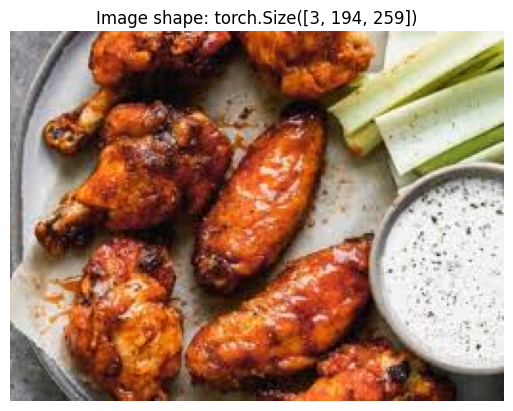

In [61]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [62]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 194, 259])
New shape: torch.Size([3, 64, 64])


In [63]:
model_1.eval()
with torch.inference_mode():

  # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

      # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [64]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.0252, -0.4390, -0.6192, -0.0443, -0.5738]])
Prediction probabilities: tensor([[0.2651, 0.1753, 0.1464, 0.2601, 0.1532]])
Prediction label: tensor([0])


In [65]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label] # put pred label to CPU, otherwise will error
custom_image_pred_class

'chicken_wings'

In [66]:
from typing import List
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

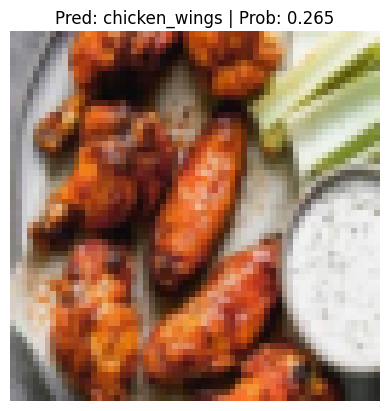

In [67]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)